<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_6_ML4HS_UC2023_The_rigth_way_of_doing_cross_validation%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(123)


# A lesson from Hastie et al. , The wrong way of doing cross validation

Consider a classification problem with a large number of predictors, as may
arise, for example, in genomic or proteomic applications. A typical strategy
for analysis might be as follows:
1. Screen the predictors: find a subset of “good” predictors that show
fairly strong (univariate) correlation with the class labels
2. Using just this subset of predictors, build a multivariate classifier.
3. Use cross-validation to estimate the unknown tuning parameters and
to estimate the prediction error of the final model.

Is this a correct application of cross-validation? Consider a scenario with
N = 50 samples in two equal-sized classes, and p = 5000 quantitative
predictors (standard Gaussian) that are independent of the class labels.
***Since they ARE independent, The true (test) error rate of any classifier is 50%. ***

We carried out the above recipe:

***Feaure selection***
choosing in step (1) the 100 predictors having highest correlation with the class labels.

***Train the classifier***

using a 1-nearest neighbor classifier, based on just these 100 predictors, in step (2).

Over 50 simulations from this setting, the average CV error rate was 3%. This is far lower than the true
error rate of 50%.

We will repeat this experience with more classifiers and you will invert the training and feature selection step to recover the rigth error rate.

In [3]:
N = 100 # events
P = 5000 # observable: gene expression, radiomincs features, columns in a dataset

n = 10 # Best features to keep after feature selection

In [4]:
np.random.seed(123)
X = np.random.randn(N,P)# data: just random gaussians
y = np.concatenate([np.zeros(int(N/2)),np.ones(int(N/2))]) # labels do not depends on data, they are random
print("data shape : ",X.shape)
print("labels shape : ", y.shape)

data shape :  (100, 5000)
labels shape :  (100,)


# Univariate feature selection:
 When the number of variables in largen than the number of the datapoints (P >> N), it is better to perform a reduction of the dataset variable.


 This step of the pipeline is called the "feature selection". There are many ways of performing this part of the analisi. The aim is to reduce the columns of the dataset while keeping only the more descriptive variable.

 In our dummy dataset we will select the variables that are better correlated with the labels. Since we are using gaussian data and binary classes the best way to do it is using a [Point-Biserial Correlation](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient).
 This measure is similar to Pearson correlation.

 For each variable, we will test if we can separate class 0 from class 1.

In [5]:
from scipy import stats

corr = np.zeros(P)
anova = np.zeros(P)
ttest = np.zeros(P)

for p in range(P):# for each variable
  # select the two classes
  X_p = X[:,p]
  class_0 = X_p[y==0]
  class_1 = X_p[y==1]

  # apply the correlation measure on the two distributions
  corr[p] , _ = stats.pointbiserialr(y, X_p)
  t_statistic, ttest[p] = stats.ttest_ind(class_0, class_1)
  f_statistic, anova[p] = stats.f_oneway(class_0,class_1)

Text(0, 0.5, 'probability')

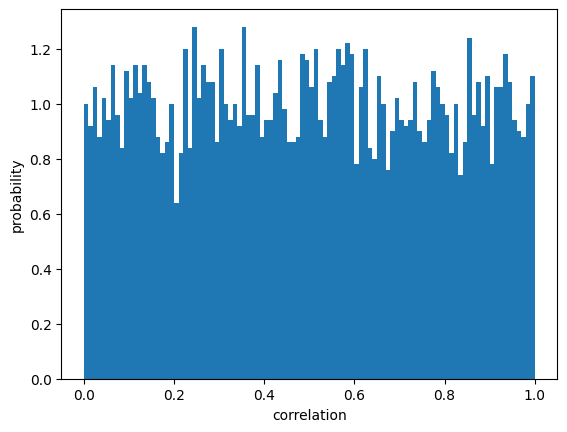

In [6]:
plt.figure()
_=plt.hist(anova,100,density=True)
plt.xlabel("correlation")
plt.ylabel("probability")

In [7]:
univariate_selection = "TTEST" # ANOVA # PEARSON

if univariate_selection == "PEARSON":
  feature_to_keep = np.argsort(np.abs(corr))[-n:]
elif univariate_selection == "TTEST":
  feature_to_keep = np.argsort(ttest)[:n]
elif univariate_selection == "ANOVA":
  feature_to_keep = np.argsort(anova)[:n]

In [8]:
np.sort(ttest)

array([1.97152760e-04, 3.52670539e-04, 5.43985978e-04, ...,
       9.99327212e-01, 9.99642189e-01, 9.99841760e-01])

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

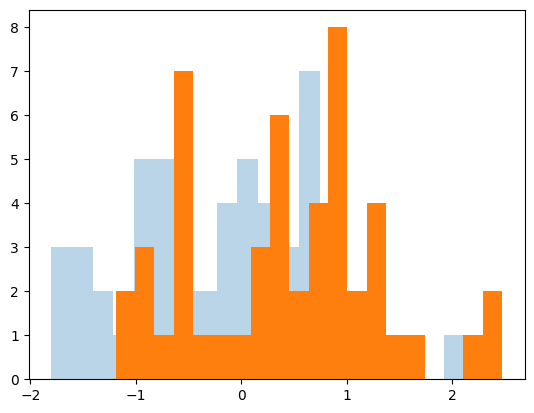

In [9]:
bf = feature_to_keep[1]
plt.figure()
_=plt.hist(X[y==0,bf],20,alpha = 0.3,)
_=plt.hist(X[y==1,bf],20)
plt.title

In [10]:
X_cut = X[:,feature_to_keep]

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

LR_scores=[]
KNN_scores=[]

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X_cut)):
  print(f"Fold {i}:")
  X_train = X_cut[train_index]
  y_train = y[train_index]
  X_test = X_cut[test_index]
  y_test = y[test_index]

  KNN = KNeighborsClassifier(n_neighbors=1)
  LR = LogisticRegression()

  LR.fit(X_train, y_train)
  KNN.fit(X_train, y_train)
  LR_score = LR.score(X_test,y_test)
  KNN_score = KNN.score(X_test,y_test)

  print("accuracy LR : ", LR_score)
  print("accuracy KNN : ", KNN_score)
  LR_scores.append(LR_score)
  KNN_scores.append(KNN_score)


Fold 0:
accuracy LR :  0.7
accuracy KNN :  0.55
Fold 1:
accuracy LR :  0.9
accuracy KNN :  0.65
Fold 2:
accuracy LR :  0.7
accuracy KNN :  0.6
Fold 3:
accuracy LR :  0.65
accuracy KNN :  0.6
Fold 4:
accuracy LR :  0.8
accuracy KNN :  0.75


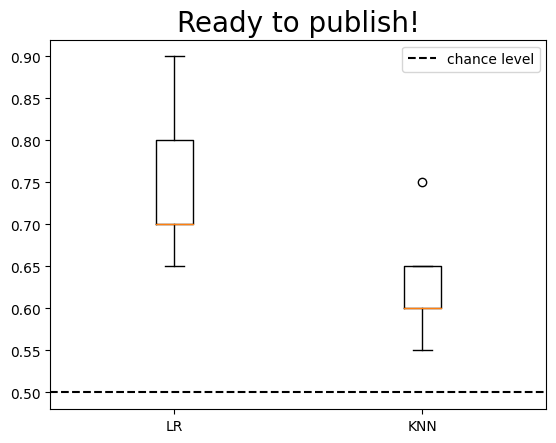

In [11]:
fig1, ax1 = plt.subplots()
ax1.set_title('Ready to publish!',fontsize=20)
ax1.boxplot([LR_scores,KNN_scores],labels=["LR","KNN"])
ax1.axhline(0.5,color="k",linestyle="--",label="chance level")
plt.legend()